In [1]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
import scipy


# OS interaction
import sys, pickle, os, yaml

# plotting packages
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
#from mpl_toolkits.basemap import Basemap

# turbulence package
import turbpy
import turbpy.multiConst as mc


import sys
sys.path.append("/home/elilouis/sublimationofsnow/")
import sosutils
from metpy.units import units
import metpy
import pint_xarray
import altair as alt
alt.data_transformers.enable('json')
import pytz

# Inputs

In [2]:
sos_download_dir='/data2/elilouis/sublimationofsnow/sosnoqc'
DATE_FORMAT_STR = '%Y%m%d'
# datelist = ['20230217', '20230218', '20230219', '20230220', '20230221']
# datelist = ['20221217', '20221218', '20221219', '20221220', '20221221']
datelist = ['20221031', '20221101', '20221102', '20221103']
start_date = datelist[0]
end_date = datelist[-1]
VARIABLE_NAMES = [  
    'spd_2m_c',     'dir_2m_c',     'u_2m_c',   'v_2m_c',   'w_2m_c',   'u_w__2m_c',    'v_w__2m_c',  'u_tc__2m_c',  'v_tc__2m_c',   'u_h2o__2m_c',  'v_h2o__2m_c',   'w_tc__2m_c',   'w_h2o__2m_c',
    'spd_3m_c',     'dir_3m_c',     'u_3m_c',   'v_3m_c',   'w_3m_c',   'u_w__3m_c',    'v_w__3m_c',  'u_tc__3m_c',  'v_tc__3m_c',   'u_h2o__3m_c',  'v_h2o__3m_c',   'w_tc__3m_c',   'w_h2o__3m_c',
    'spd_5m_c',     'dir_5m_c',     'u_5m_c',   'v_5m_c',   'w_5m_c',   'u_w__5m_c',    'v_w__5m_c',  'u_tc__5m_c',  'v_tc__5m_c',   'u_h2o__5m_c',  'v_h2o__5m_c',   'w_tc__5m_c',   'w_h2o__5m_c',
    'spd_10m_c',    'dir_10m_c',    'u_10m_c',  'v_10m_c',  'w_10m_c',  'u_w__10m_c',   'v_w__10m_c', 'u_tc__10m_c', 'v_tc__10m_c',  'u_h2o__10m_c', 'v_h2o__10m_c',  'w_tc__10m_c',  'w_h2o__10m_c',
    'spd_15m_c',    'dir_15m_c',    'u_15m_c',  'v_15m_c',  'w_15m_c',  'u_w__15m_c',   'v_w__15m_c', 'u_tc__15m_c', 'v_tc__15m_c',  'u_h2o__15m_c', 'v_h2o__15m_c',  'w_tc__15m_c',  'w_h2o__15m_c',
    'spd_20m_c',    'dir_20m_c',    'u_20m_c',  'v_20m_c',  'w_20m_c',  'u_w__20m_c',   'v_w__20m_c', 'u_tc__20m_c', 'v_tc__20m_c',  'u_h2o__20m_c', 'v_h2o__20m_c',  'w_tc__20m_c',  'w_h2o__20m_c',
    
     'tc_2m_c', 'tc_3m_c', 'tc_5m_c', 'tc_10m_c', 'tc_15m_c', 'tc_20m_c',

     'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c',
    'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c',
    'T_11m_c', 'T_12m_c', 'T_13m_c', 'T_14m_c', 'T_15m_c',
    'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c', 'T_20m_c',

    'P_20m_c',
    'P_10m_c', 'P_10m_d', 'P_10m_uw', 'P_10m_ue',

     'RH_2m_c', 'RH_3m_c', 'RH_4m_c', 'RH_5m_c', 'RH_6m_c', 'RH_7m_c', 'RH_8m_c', 'RH_9m_c', 'RH_10m_c',
    'RH_11m_c','RH_12m_c','RH_13m_c','RH_14m_c','RH_15m_c','RH_16m_c','RH_17m_c','RH_18m_c','RH_19m_c','RH_20m_c',

    'SF_avg_1m_ue', 'SF_avg_2m_ue',

    "Vtherm_c", "Vtherm_d", "Vtherm_ue", "Vtherm_uw", 
    "Vpile_c", "Vpile_d", "Vpile_ue", "Vpile_uw",
    "IDir_c", "IDir_d", "IDir_ue", "IDir_uw",
]

# Download SoS data

In [3]:
datasets = [xr.open_dataset(sosutils.download_sos_data_day(date, sos_download_dir))[VARIABLE_NAMES] for date in datelist]
sos_ds = sosutils.merge_datasets_with_different_variables(datasets, dim='time')

# Add additional variables to the dataset

In [4]:
# Potential Temperature
# iterate over pressure measurements
for i in range(2,21):
    height_adj_pressure = metpy.calc.add_height_to_pressure(
        sos_ds['P_10m_c'] * units.millibar, 
        i*units.m - (10*units.m)
    )
    sos_ds[f'Tpot_{i}m_c'] = metpy.calc.potential_temperature(    
        height_adj_pressure,
        sos_ds[f'T_{i}m_c'] * units.celsius
    ).pint.to(units.celsius)

# Surface Temperature
# calculate from apogees
sos_ds['Tsurf_c'] = (['time'],  sosutils.apogee2temp(sos_ds, 'c').magnitude)
sos_ds['Tsurf_d'] = (['time'],  sosutils.apogee2temp(sos_ds, 'd').magnitude)
sos_ds['Tsurf_ue'] = (['time'],  sosutils.apogee2temp(sos_ds, 'ue').magnitude)

# Get Tidy Dataset

In [5]:
vars = VARIABLE_NAMES + ['Tsurf_c','Tsurf_d', 'Tsurf_ue']
tidy_df = sosutils.get_tidy_dataset(sos_ds, vars)
tidy_df = sosutils.modify_df_timezone(tidy_df, pytz.UTC, pytz.timezone('US/Mountain'))

# Calculate Richardson Number with turbpy

In [6]:
sfcTemp = (tidy_df.query("variable == 'Tsurf_c'")['value']+273.15).fillna(method='ffill')
airTemp = (tidy_df.query("variable == 'T_2m_c'")['value']+273.15).fillna(method='ffill')
windspd = (tidy_df.query("variable == 'spd_2m_c'")['value']).fillna(method='ffill')
airPressure = ((tidy_df.query("variable == 'P_10m_c'")['value']).fillna(method='ffill').values * units.millibar).to(units.pascal).magnitude
mHeight = 2
snowDepth = 1 

(airVaporPress, _) = turbpy.satVapPress(airTemp - 273.15)
(sfcVaporPress, _) = turbpy.satVapPress(sfcTemp - 273.15)


RiBulk = turbpy.bulkRichardson(
    airTemp.values,
    sfcTemp.values,
    windspd.values,
    mHeight
)

## Combine results into tidy df

In [7]:
ribulk_data = pd.DataFrame({
    'time': tidy_df.time.drop_duplicates(),
    'value': RiBulk
}).assign(
    variable = 'Ri_2m_c',
    measurement = 'Richardson Number',
    height = 2,
    tower = 'c'
)

tidy_df = pd.concat([tidy_df, ribulk_data])

In [8]:
alt.renderers.enable('svg')

RendererRegistry.enable('svg')

In [9]:
temp_chart = alt.Chart(tidy_df).transform_filter(
    alt.FieldOneOfPredicate('variable', ['Tsurf_c', 'Tsurf_d', 'Tsurf_ue', 'T_2m_c'])
).mark_line().encode(
    alt.X('time:T'),
    alt.Y("value:Q"),
    alt.Color("variable:N")
).properties(width=800, height=200)

In [10]:
w_h2o_chart = alt.Chart(tidy_df).transform_filter(
    alt.FieldOneOfPredicate('measurement', ['w_h2o_'])
).mark_line().transform_window(
    rolling_mean='mean(value)',
    frame=[-10, 10],
    groupby=['variable']
).encode(
    alt.X('time:T'),
    alt.Y("rolling_mean:Q", scale=alt.Scale(domain=[-0.1, 0.1], clamp=True, nice=False)),
    alt.Color("height:O", scale=alt.Scale(scheme='viridis'))
).properties(width=800, height=200)

In [11]:
wind_speed_chart = alt.Chart(tidy_df).transform_filter(
    alt.FieldOneOfPredicate('variable', ['spd_2m_c', 'spd_3m_c'])
).mark_line().encode(
    alt.X('time:T'),
    alt.Y("value:Q"),
    alt.Color("variable:N")
).properties(width=800, height=200)

In [12]:
richardson_chart = alt.Chart(tidy_df).transform_filter(
    alt.FieldOneOfPredicate('variable', ['Ri_2m_c'])
).mark_line().encode(
    alt.X('time:T'),
    alt.Y("value:Q"),
    alt.Color("variable:N")
).properties(width=800, height=200)

# Set up multipoy turby schemes in dictionaries

In [13]:
# stab_titles are the names given to each stability scheme when plotting. In this example they correspond 
# to the dictionaries that contain the parameter values for each run. T
stab_titles = ('Standard',
            #    'Louis (b = 4.7)',
            #    'Louis (b = 12)',
            #    'Louis (Ri capped, MJ98)',
               'MO (Holtslag/de Bruin)',
            #    'MO (Holtslag/de Bruin - capped)',
               'MO (Beljaars/Holtslag)',
            #    'MO (Webb - NoahMP)',
               'MO (Cheng/Brutsaert)',
              )

# A mapping between the titles and the stability methods used in each test.
stab_methods = {'Standard': 'standard',
                # 'Louis (b = 4.7)': 'louis',
                # 'Louis (b = 12)': 'louis',
                # 'Louis (Ri capped, MJ98)': 'louis',
                'MO (Holtslag/de Bruin)': 'monin_obukhov',
                # 'MO (Holtslag/de Bruin - capped)': 'monin_obukhov',
                'MO (Beljaars/Holtslag)': 'monin_obukhov',
                # 'MO (Webb - NoahMP)': 'monin_obukhov',
                'MO (Cheng/Brutsaert)': 'monin_obukhov',
               }

# Thes gradient functions for the Monin-Obukhov methods
gradient_funcs = {'MO (Holtslag/de Bruin)': 'holtslag_debruin',
                #   'MO (Holtslag/de Bruin - capped)': 'holtslag_debruin',
                  'MO (Beljaars/Holtslag)': 'beljaar_holtslag',
                #   'MO (Beljaars/Holtslag - capped)': 'beljaar_holtslag',
                  'MO (Cheng/Brutsaert)': 'cheng_brutsaert',
                #   'MO (Webb - NoahMP)': 'webb_noahmp',
                 }

# Parameters for the Louis scheme. Any method without a parameter value provided 
# is filled in with the default value
params = {'Louis (b = 4.7)': 9.4,
          'Louis (Ri capped, MJ98)': 9.4,
          'Louis (b = 12)': 24.}

# Indicates which methods have capping of the conductance. Any method without capping 
# indicated is assumed to have no capping.
capping = {
    'Louis (Ri capped, MJ98)': 'louis_Ri_capping',
    'MO (Holtslag/de Bruin - capped)': 'windless_exchange',
    }

# Initialize the multi-level parameter dictionary
stab_dict = {}
# stab_dict['stability_params'] = {}

for st in stab_methods:
    stab_dict[st] = {}
    
    # Assigning the stability method
    stab_dict[st]['stability_method'] = stab_methods[st]
    
    # Assigning the gradient method
    if 'monin_obukhov' in stab_methods[st]:
        stab_dict[st]['monin_obukhov'] = {}
        stab_dict[st]['monin_obukhov']['gradient_function'] = gradient_funcs[st]
        
    # Assiging the capping behavior
    if st in capping.keys():
        stab_dict[st]['capping'] = capping[st]
    
    # Determine stability params
    if st in params.keys():
        stab_dict[st]['stability_params'] = {stab_methods[st]: params[st]}    

# Calculate modeled latent and sensible heat fluxes

In [14]:

## Calculate stability

# Initialzie dictionaries for containing output
stability_correction = {}
conductance_sensible = {}
conductance_latent = {}
sensible_heat = {}
latent_heat = {}
zeta = {}

for stab in stab_titles:
    stability_correction[stab] = np.zeros_like(RiBulk)
    conductance_sensible[stab] = np.zeros_like(RiBulk)
    conductance_latent[stab] = np.zeros_like(RiBulk)
    sensible_heat[stab] = np.zeros_like(RiBulk)
    latent_heat[stab] = np.zeros_like(RiBulk)
    zeta[stab] = np.zeros_like(RiBulk)
 
## Calculate stability
for stab in stab_titles:
    for n, (tair, vpair, tsfc, vpsfc, u, airP) in enumerate(zip(airTemp, airVaporPress, sfcTemp, sfcVaporPress, windspd, airPressure)):

        # Offline Turbulence Package
        (conductance_sensible[stab][n], 
         conductance_latent[stab][n], 
         sensible_heat[stab][n],
         latent_heat[stab][n],
         stab_output, p_test) = turbpy.turbFluxes(tair, airP,
                                                  vpair, u, tsfc,
                                                  vpsfc, snowDepth,
                                                  mHeight, param_dict=stab_dict[stab],
                                                  z0Ground=.005)
        
        # Unpack stability parameters dictionary
        if not 'monin_obukhov' in stab_methods[stab]:
            stability_correction[stab][n] = stab_output['stabilityCorrection']
        else:
            stability_correction[stab][n] = np.nan
            zeta[stab][n] = stab_output['zeta']

## Combine results into tidy df

Note that we use the opposite convention of turbpy - latent and sensible heat fluxes should be positive upward

Also we calculate:
*  vertical water vapor moisture flux (m/s * g/m^2) using the latent heat of sublimation
*  rolling average measured EC water vapor moisture flux

In [15]:
for stab in stab_titles:
    
    latent_heat_data = pd.DataFrame({
        'time': tidy_df.time.drop_duplicates(),
        'value': - latent_heat[stab]
    }).assign(
        variable = None,
        measurement = f'latent heat flux modeled {stab}',
        height = 2,
        tower = 'c'
    )

    water_vapor_flux_data = pd.DataFrame({
        'time': tidy_df.time.drop_duplicates(),
        'value': - latent_heat[stab]/(2838)
    }).assign(
        variable = None,
        measurement = f'w_h2o_ modeled {stab}',
        height = 2,
        tower = 'c'
    )

    sensible_heat_data = pd.DataFrame({
        'time': tidy_df.time.drop_duplicates(),
        'value': - sensible_heat[stab]
    }).assign(
        variable = None,
        measurement = 'sensible heat flux modeled {stab}',
        height = 2,
        tower = 'c'
    )

    sensible_heat_data = pd.DataFrame({
        'time': tidy_df.time.drop_duplicates(),
        'value': - sensible_heat[stab]
    }).assign(
        variable = None,
        measurement = 'sensible heat flux modeled {stab}',
        height = 2,
        tower = 'c'
    )
    tidy_df = pd.concat([tidy_df, latent_heat_data, sensible_heat_data, water_vapor_flux_data])

In [16]:
tidy_df.measurement.unique()

array(['wind speed', 'wind direction', 'u', 'v', 'w', 'u_w_', 'v_w_',
       'u_tc_', 'v_tc_', 'u_h2o_', 'v_h2o_', 'w_tc_', 'w_h2o_',
       'virtual temperature', 'temperature', 'pressure', 'RH',
       'snow flux', 'Vtherm', 'Vpile', 'IDir', 'surface temperature',
       'Richardson Number', 'latent heat flux modeled Standard',
       'sensible heat flux modeled {stab}', 'w_h2o_ modeled Standard',
       'latent heat flux modeled MO (Holtslag/de Bruin)',
       'w_h2o_ modeled MO (Holtslag/de Bruin)',
       'latent heat flux modeled MO (Beljaars/Holtslag)',
       'w_h2o_ modeled MO (Beljaars/Holtslag)',
       'latent heat flux modeled MO (Cheng/Brutsaert)',
       'w_h2o_ modeled MO (Cheng/Brutsaert)'], dtype=object)

In [17]:
model_chart = alt.Chart(tidy_df).transform_filter(
    alt.datum.height == 2
).transform_filter(
    alt.FieldOneOfPredicate('measurement', [
        'w_h2o_', 
        'w_h2o_ modeled Standard',
        'w_h2o_ modeled MO (Holtslag/de Bruin)', 
    ])
).transform_window(
    rolling_mean='mean(value)',
    frame=[-6, 6],
    groupby=['measurement']
).mark_line().encode(
    alt.X('time:T'),
    alt.Y("rolling_mean:Q", ),
    alt.Color("measurement:N")
).properties(width=800, height=200)

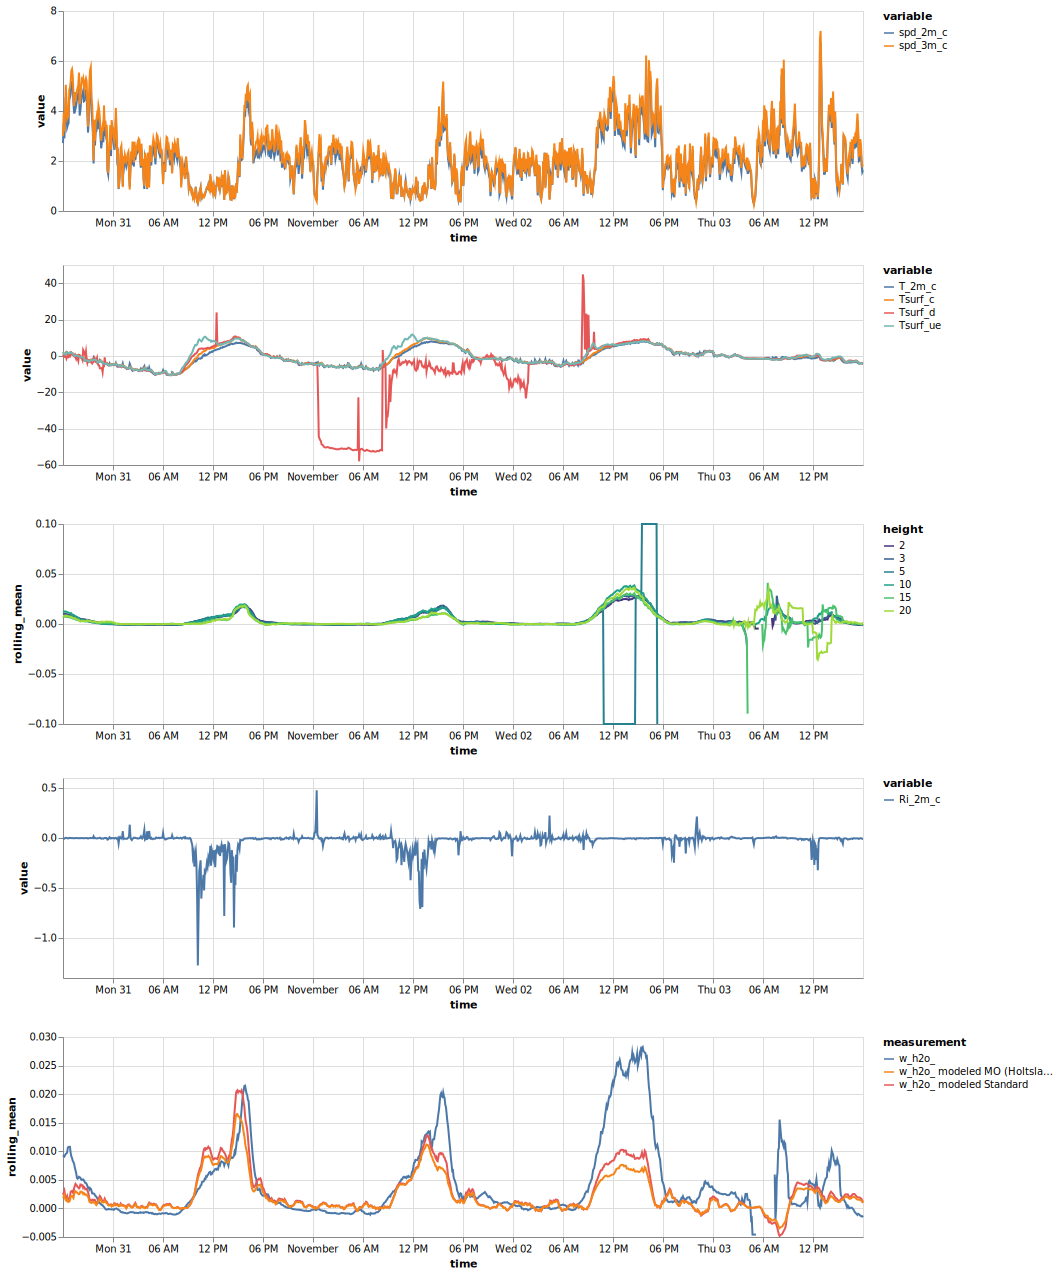

In [18]:
(wind_speed_chart & temp_chart & w_h2o_chart & richardson_chart & model_chart).resolve_scale(color='independent', x='shared')

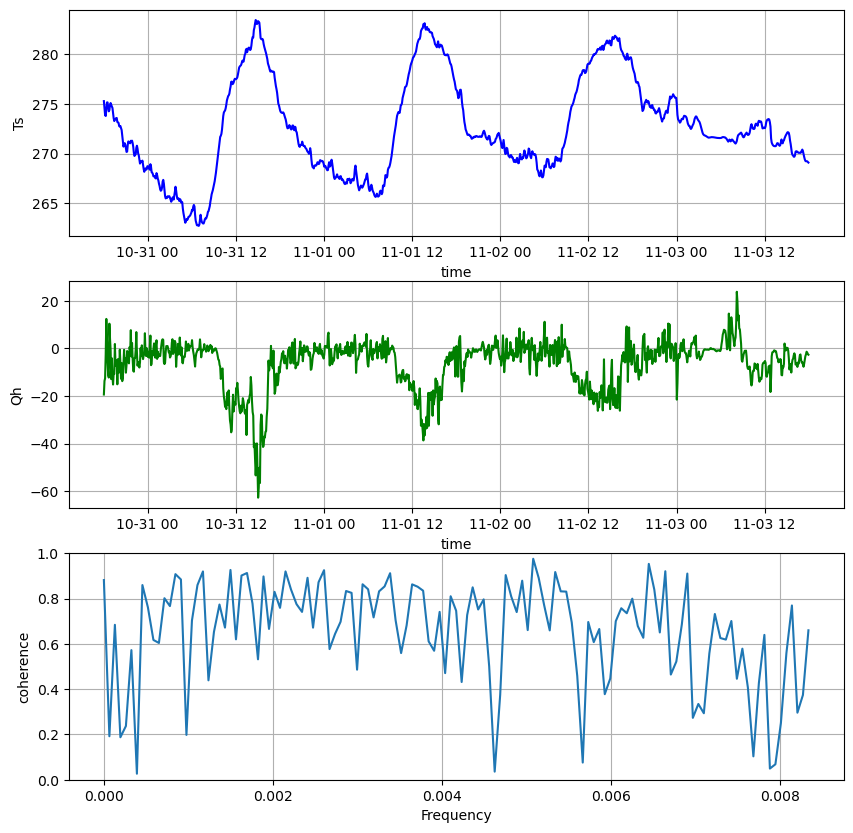

In [19]:
datetimes = tidy_df.time.drop_duplicates()
"""
Compute the coherence of two signals
Coherence is the normalized cross spectral density
--------------------------------------------------------
https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.cohere.html
https://matplotlib.org/examples/pylab_examples/cohere_demo.html
https://stackoverflow.com/questions/21647120/how-to-use-the-cross-spectral-density-to-calculate-the-phase-shift-of-two-relate
"""
# indicies if I want to look at a shorter time span
n, m = [0,len(datetimes)]

nfft = 256
dt = 60
t = np.arange(0, len(datetimes[n:m]), dt)
r = np.exp(-t/0.05)

# our two signals
s1 = sfcTemp[n:m] # snow surface temperature, Ts
s2 = latent_heat['MO (Holtslag/de Bruin)'][n:m] # Sensible heat flux, Qh

plt.figure(figsize=(10,10))
plt.subplot(311)
plt.plot(datetimes[n:m], s1, 'b-')
#plt.xlim(0,5)
plt.xlabel('time')
plt.ylabel('Ts')
plt.grid(True)

plt.subplot(312)
plt.plot(datetimes[n:m], s2, 'g-')
#plt.xlim(0,5)
plt.xlabel('time')
plt.ylabel('Qh')
plt.grid(True)

plt.subplot(313)
cxy, f = plt.cohere(s1, s2, nfft, 1./dt)
plt.ylim((0,1))
plt.ylabel('coherence')
plt.show()

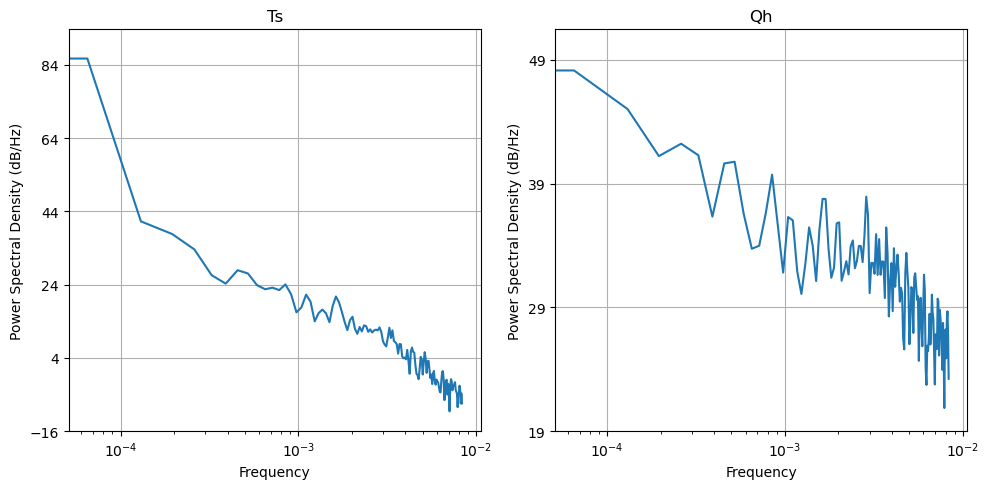

In [20]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.psd(s1, nfft, 1/dt)
plt.title('Ts')
plt.xscale('log')

plt.subplot(122)
plt.psd(s2, nfft, 1/dt)
plt.title('Qh')
plt.xscale('log')

plt.tight_layout()
plt.show()


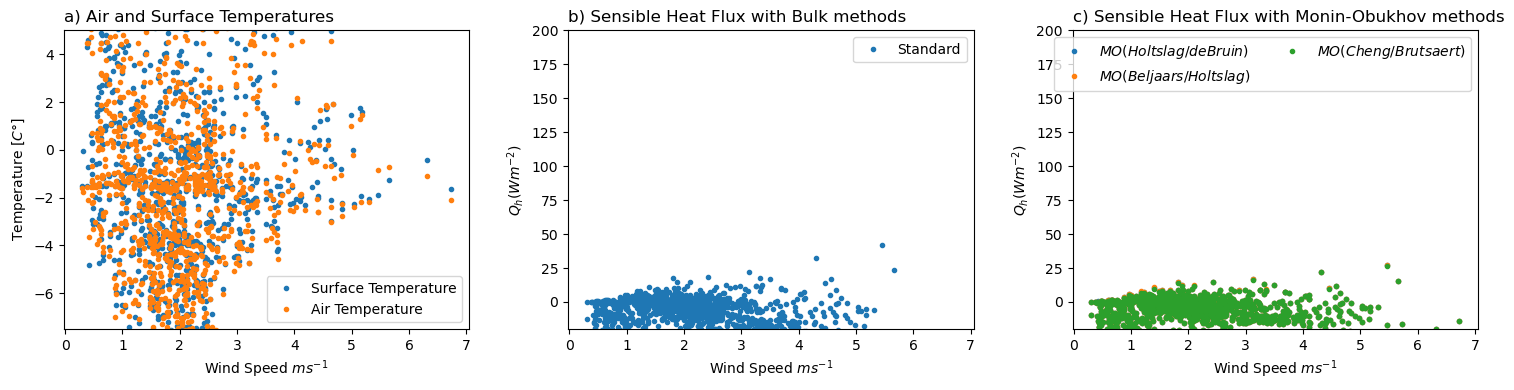

In [21]:
# Figure
fig, axes = plt.subplots(1,3, figsize=(15, 4))
axes = axes.flatten()

# Plotting parameters
Qmax = 200
Qmin = -20
RiMax = np.max(RiBulk)
RiMin = np.min(RiBulk)

# Temperatures
ax = axes[0]
ax.plot(windspd, sfcTemp-273.15, '.', label='Surface Temperature')
ax.plot(windspd, airTemp-273.15, '.', label='Air Temperature')
ax.set_ylabel('Temperature [$C\degree$]')
ax.set_xlabel('Wind Speed $m s^{-1}$')
ax.set_ylim(-7.5,5)
ax.set_title('a) Air and Surface Temperatures', loc='left')
lgd = ax.legend(loc='lower right', frameon=True)

# Bulk methods
for stab in stab_titles:
    if stab_dict[stab]['stability_method'] == 'monin_obukhov':
        continue

    # b) Bulk Sensible Heat Flux
    ax = axes[1]
    ax.plot(windspd, sensible_heat[stab], '.', label=stab)#, color=colr[title]



ax = axes[1]
#ax.plot([0, 0], [Qmin, Qmax], 'k--')
ax.set_ylim(Qmin, Qmax)
ax.set_xlabel('Wind Speed $m s^{-1}$')
ax.set_ylabel('$Q_h (Wm^{-2}$)')
ax.set_title('b) Sensible Heat Flux with Bulk methods', loc='left')
lgd = ax.legend(loc='upper right', frameon=True)

# Monin Obukhov methods
for stab in stab_titles:
    if not stab_dict[stab]['stability_method'] == 'monin_obukhov':
        continue
    

    # d) MO Sensible Heat Flux
    ax = axes[2]
    ax.plot(windspd, sensible_heat[stab], '.', label='$' + stab + '$')#, color=colr[title]
    

ax = axes[2]
#ax.plot([0, 0], [Qmin, Qmax], 'k--')
ax.set_ylim(Qmin, Qmax)
ax.set_xlabel('Wind Speed $m s^{-1}$')
ax.set_ylabel('$Q_h (Wm^{-2}$)')
ax.set_title('c) Sensible Heat Flux with Monin-Obukhov methods', loc='left')
lgd = ax.legend(loc='upper right', frameon=True, ncol=2)

fig.tight_layout()
#fig.autofmt_xdate()

# Save the figure
#os.chdir(workbookDir)
#fig.savefig('turbpy.idealized2.jpg', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)

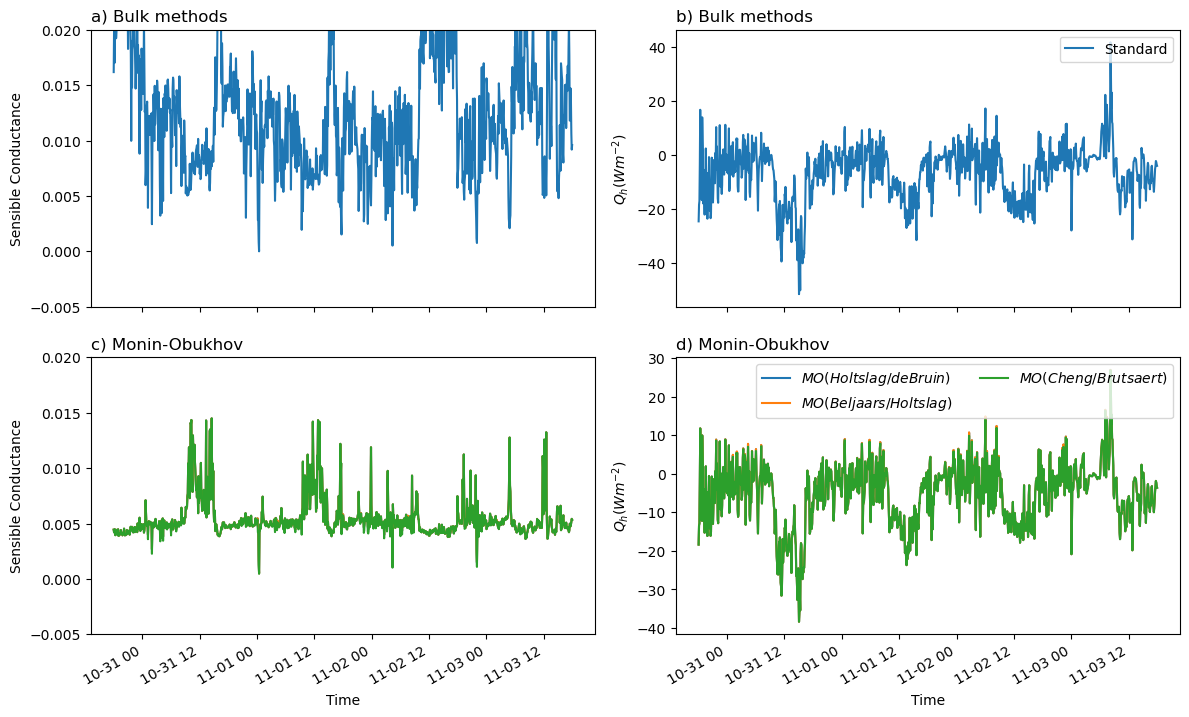

In [22]:
datetimes = tidy_df.time.drop_duplicates()
# Figure
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# Plotting parameters
Qmax = 40
Qmin = -20
RiMax = np.max(RiBulk)
RiMin = np.min(RiBulk)

# Bulk methods
for stab in stab_titles:
    if stab_dict[stab]['stability_method'] == 'monin_obukhov':
        continue
    
    # a) Bulk Conductance
    ax = axes[0]
    ax.plot(datetimes, conductance_sensible[stab])#, color=colr[title])

    # b) Bulk Sensible Heat Flux
    ax = axes[1]
    ax.plot(datetimes, sensible_heat[stab], label=stab)#, color=colr[title]

# Format the plots
ax = axes[0]
#ax.plot([0, 0], [0., 0.1], 'k--')
ax.set_ylim(-0.005,0.02)
#ax.set_xlim(RiMin, RiMax)
ax.set_ylabel('Sensible Conductance')
#ax.set_xlabel('Ri #')
ax.set_title('a) Bulk methods', loc='left')


ax = axes[1]
#ax.plot([0, 0], [Qmin, Qmax], 'k--')
#ax.set_ylim(Qmin, Qmax)
#ax.set_xlim(RiMin, RiMax)
#ax.set_xlabel('Ri #')
ax.set_ylabel('$Q_h (Wm^{-2}$)')
ax.set_title('b) Bulk methods', loc='left')
lgd = ax.legend(loc='upper right', frameon=True)

# Monin Obukhov methods
for stab in stab_titles:
    if not stab_dict[stab]['stability_method'] == 'monin_obukhov':
        continue
    
    # c) MO Conductance
    ax = axes[2]
    ax.plot(datetimes, conductance_sensible[stab])#, color=colr[title])

    # d) MO Sensible Heat Flux
    ax = axes[3]
    ax.plot(datetimes, sensible_heat[stab], label='$' + stab + '$')#, color=colr[title]
    
# Format the plots
ax = axes[2]
#ax.plot([0, 0], [0., 0.1], 'k--')
ax.set_ylim(-0.005,0.02)
#ax.set_xlim(RiMin, RiMax)
ax.set_ylabel('Sensible Conductance')
ax.set_xlabel('Time')
ax.set_title('c) Monin-Obukhov', loc='left')

ax = axes[3]
#ax.plot([0, 0], [Qmin, Qmax], 'k--')
#ax.set_ylim(Qmin, Qmax)
#ax.set_xlim(RiMin, RiMax)
ax.set_xlabel('Time')
ax.set_ylabel('$Q_h (Wm^{-2}$)')
ax.set_title('d) Monin-Obukhov', loc='left')
lgd = ax.legend(loc='upper right', frameon=True, ncol=2)

fig.tight_layout()
fig.autofmt_xdate()

# Save the figure
#os.chdir(workbookDir)
#fig.savefig('turbpy.idealized2.jpg', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)

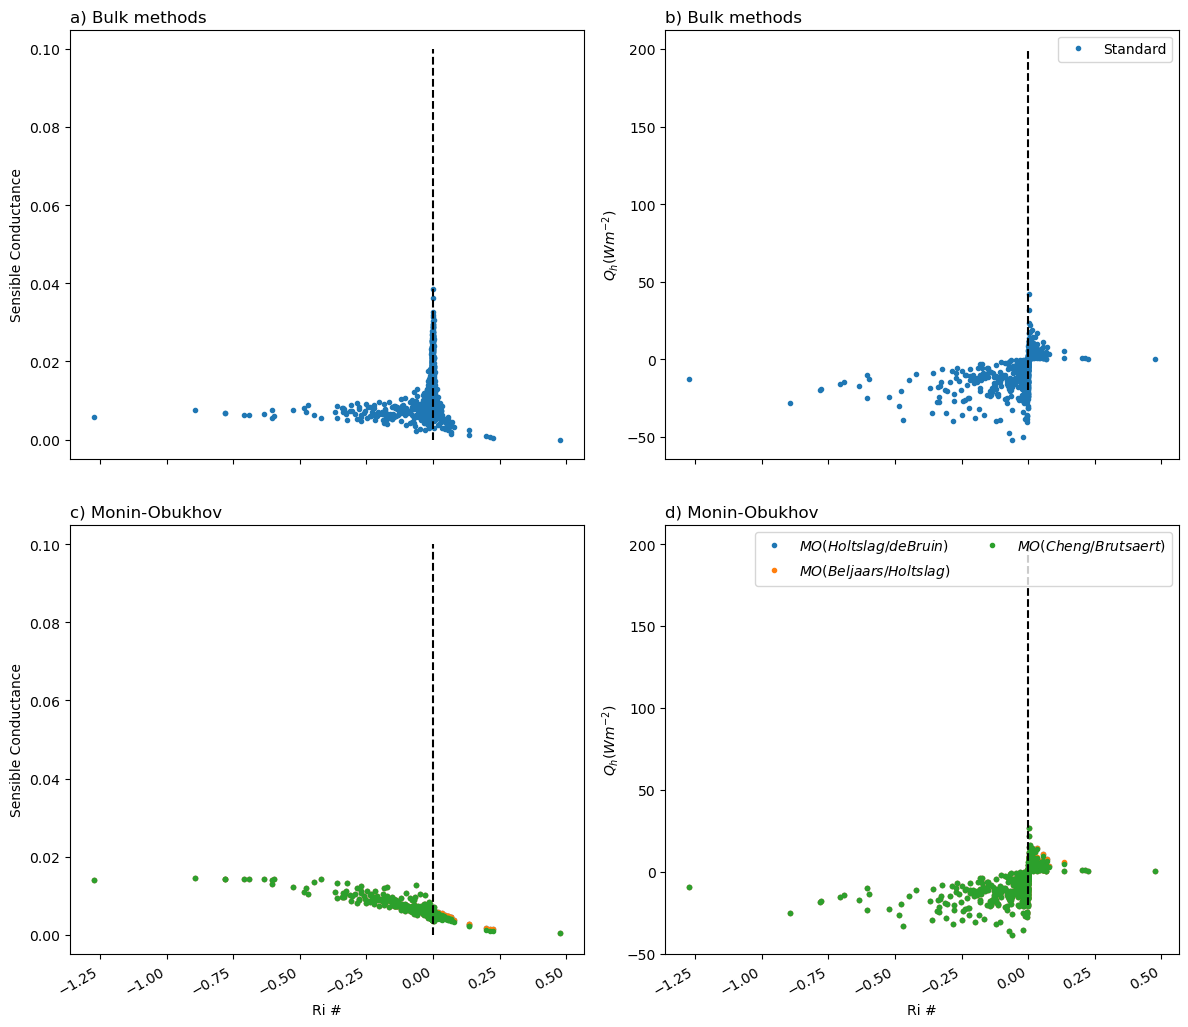

In [23]:
# Figure
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

# Plotting parameters
Qmax = 200
Qmin = -20
RiMax = 1.5#np.max(RiBulk)
RiMin = -0.1#np.min(RiBulk)

# Bulk methods
for stab in stab_titles:
    if stab_dict[stab]['stability_method'] == 'monin_obukhov':
        continue
    
    # a) Bulk Conductance
    ax = axes[0]
    ax.plot(RiBulk, conductance_sensible[stab], '.')#, color=colr[title])

    # b) Bulk Sensible Heat Flux
    ax = axes[1]
    ax.plot(RiBulk, sensible_heat[stab], '.', label=stab)#, color=colr[title]

# Format the plots
ax = axes[0]
ax.plot([0, 0], [0., 0.1], 'k--')
# ax.set_ylim(0,0.01)
# ax.set_xlim(RiMin, RiMax)
ax.set_ylabel('Sensible Conductance')
ax.set_xlabel('Ri #')
ax.set_title('a) Bulk methods', loc='left')


ax = axes[1]
ax.plot([0, 0], [Qmin, Qmax], 'k--')
# ax.set_ylim(Qmin, Qmax)
# ax.set_xlim(RiMin, RiMax)
ax.set_xlabel('Ri #')
ax.set_ylabel('$Q_h (Wm^{-2}$)')
ax.set_title('b) Bulk methods', loc='left')
lgd = ax.legend(loc='upper right', frameon=True)

# Monin Obukhov methods
for stab in stab_titles:
    if not stab_dict[stab]['stability_method'] == 'monin_obukhov':
        continue
    
    # c) MO Conductance
    ax = axes[2]
    ax.plot(RiBulk, conductance_sensible[stab], '.')#, color=colr[title])

    # d) MO Sensible Heat Flux
    ax = axes[3]
    ax.plot(RiBulk, sensible_heat[stab], '.', label='$' + stab + '$')#, color=colr[title]
    
# Format the plots
ax = axes[2]
ax.plot([0, 0], [0., 0.1], 'k--')
# ax.set_ylim(0,0.01)
# ax.set_xlim(RiMin, RiMax)
ax.set_ylabel('Sensible Conductance')
ax.set_xlabel('Ri #')
ax.set_title('c) Monin-Obukhov', loc='left')

ax = axes[3]
ax.plot([0, 0], [Qmin, Qmax], 'k--')
# ax.set_ylim(Qmin, Qmax)
# ax.set_xlim(RiMin, RiMax)
ax.set_xlabel('Ri #')
ax.set_ylabel('$Q_h (Wm^{-2}$)')
ax.set_title('d) Monin-Obukhov', loc='left')
lgd = ax.legend(loc='upper right', frameon=True, ncol=2)

fig.tight_layout()
fig.autofmt_xdate()

# Save the figure
#os.chdir(workbookDir)
#fig.savefig('turbpy.idealized.jpg', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)
